In [1]:
%%HTML
<style> div.output {flex-direction: row} div.output > div:only-child {width: 100%} </style>

In [2]:
import numpy
numpy.set_printoptions(linewidth=numpy.nan)

<img style="margin-left: auto; margin-right: auto; width: 50%" src="uproot-3.png"></img>

What's new?

   * more modularization
   * writing files
   * jagged array operations

## More modularization

uproot 2 had been a single library (depending on Numpy and lz4).

<img style="margin-left: auto; margin-right: auto; width: 80%" src="abstraction-layers-before.png"></img>

## More modularization

uproot 3 splits out everything that is not I/O. We'll see the advantage in a moment.

<img style="margin-left: auto; margin-right: auto; width: 80%" src="abstraction-layers.png"></img>

## Writing files

uproot can now write histograms to files. It has the same dict-like interface as reading:

In [3]:
import uproot
import numpy

f = uproot.recreate("tmp.root")                                  # instead of uproot.open
f["name"] = numpy.histogram(numpy.random.normal(0, 1, 100000))   # any kind of histogram

In [4]:
f["name"].show()                                                 # read it back out

                          0                                                37827
                          +----------------------------------------------------+
[-inf, -5.7608)     0     |                                                    |
[-5.7608, -4.7735)  1     |                                                    |
[-4.7735, -3.7863)  4     |                                                    |
[-3.7863, -2.7991)  257   |                                                    |
[-2.7991, -1.8118)  3257  |****                                                |
[-1.8118, -0.82459) 16791 |***********************                             |
[-0.82459, 0.16265) 36026 |**************************************************  |
[0.16265, 1.1499)   31168 |*******************************************         |
[1.1499, 2.1371)    10861 |***************                                     |
[2.1371, 3.1244)    1533  |**                                                  |
[3.1244, 4.1116)    102   | 

In [5]:
import ROOT
c = ROOT.TCanvas()

Welcome to JupyROOT 6.14/04


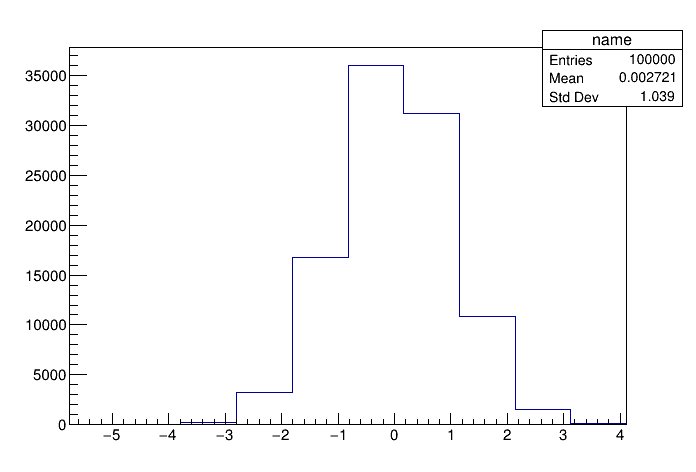

In [6]:
f = ROOT.TFile("tmp.root")                    # ROOT can read it, too
h = f.Get("name")
h.Draw()
c.Draw()

In [7]:
f = ROOT.TFile("tmp.root", "UPDATE")          # ROOT can add to the same file, too
h = ROOT.TH1D("another", "", 10, -5, 5)
for x in numpy.random.normal(0, 1, 100000):
    h.Fill(x)
h.Write()
f.Close()

In [8]:
f = uproot.open("tmp.root")
f["another"].show()

                 0                                                         36112
                 +-------------------------------------------------------------+
[-inf, -5) 0     |                                                             |
[-5, -4)   2     |                                                             |
[-4, -3)   120   |                                                             |
[-3, -2)   2208  |****                                                         |
[-2, -1)   13518 |***********************                                      |
[-1, 0)    34392 |**********************************************************   |
[0, 1)     33940 |*********************************************************    |
[1, 2)     13600 |***********************                                      |
[2, 3)     2094  |****                                                         |
[3, 4)     123   |                                                             |
[4, 5)     3     |          

uproot could become a clearinghouse for histograms from different libraries.

In [9]:
%matplotlib inline
import physt                       # physt is a pure Python histogram library: https://physt.readthedocs.io

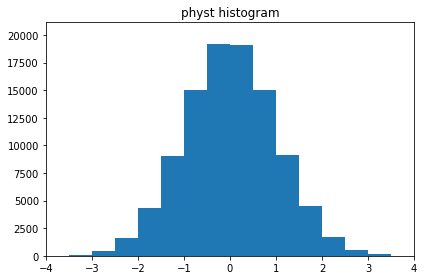

In [10]:
h = physt.h1(numpy.random.normal(0, 1, 100000), bins=16, range=(-4, 4), name="physt histogram")
h.plot();

In [11]:
f = uproot.recreate("tmp.root")   # save the physt histogram as a TH1D (making the necessary translations)
f["name"] = h

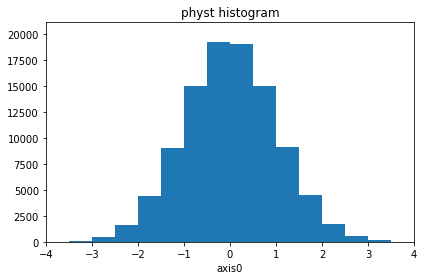

In [12]:
f = uproot.open("tmp.root")       # read the ROOT histogram back and convert it to physt
f["name"].physt().plot();

In [13]:
f["name"].numpy()                  # or Numpy, a format Matplotlib recognizes

(array([   23,   112,   473,  1652,  4370,  9061, 15024, 19213, 19091, 15019,  9128,  4501,  1671,   512,   128,    16], dtype=int32),
 array([-4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ]))

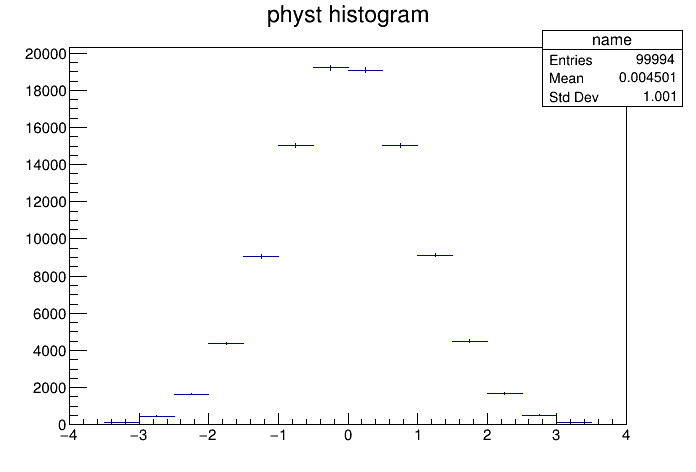

In [14]:
f = ROOT.TFile("tmp.root")         # but look, it's really a ROOT file; ROOT recognizes it as a histogram
h = f.Get("name")
h.Draw()
c.Draw()

This can also include new ways of representing histograms.

In [15]:
f = uproot.open("tmp.root")
print(f["name"].hepdata())      # YAML format for the HEPData archival site

dependent_variables:
- header: {name: counts, units: null}
  qualifiers: []
  values:
  - errors:
    - {label: stat, symerror: 4.795831523312719}
    value: 23.0
  - errors:
    - {label: stat, symerror: 10.583005244258363}
    value: 112.0
  - errors:
    - {label: stat, symerror: 21.748563170931547}
    value: 473.0
  - errors:
    - {label: stat, symerror: 40.64480286580315}
    value: 1652.0
  - errors:
    - {label: stat, symerror: 66.10597552415364}
    value: 4370.0
  - errors:
    - {label: stat, symerror: 95.1892851112981}
    value: 9061.0
  - errors:
    - {label: stat, symerror: 122.5724275683565}
    value: 15024.0
  - errors:
    - {label: stat, symerror: 138.61096637712328}
    value: 19213.0
  - errors:
    - {label: stat, symerror: 138.17018491700733}
    value: 19091.0
  - errors:
    - {label: stat, symerror: 122.55202976695246}
    value: 15019.0
  - errors:
    - {label: stat, symerror: 95.5405672999695}
    value: 9128.0
  - errors:
    - {label: stat, symerror: 

Including an idea I've been working on: Pandas DataFrames with an interval index _are_ histograms.

In [16]:
f = uproot.open("tmp.root")
h = f["name"].pandas()              # read the histogram as a DataFrame with interval index
h

,count,variance
physt histogram,,
"[-inf, -4.0)",5,0.0
"[-4.0, -3.5)",23,23.0
"[-3.5, -3.0)",112,112.0
"[-3.0, -2.5)",473,473.0
"[-2.5, -2.0)",1652,1652.0
"[-2.0, -1.5)",4370,4370.0
"[-1.5, -1.0)",9061,9061.0
"[-1.0, -0.5)",15024,15024.0
"[-0.5, 0.0)",19213,19213.0


In [17]:
f = uproot.recreate("tmp.root")     # write DataFrames in the same format as ROOT histograms
f["another"] = h

Given the way Pandas handles indexes (interval indexes in particular), Pandas-as-histograms are sparse histograms.

In [18]:
f = uproot.recreate("tmp.root")
f["one"]   = numpy.histogram(numpy.random.normal(1, 0.6, 10000), bins=8, range=(0, 8))
f["two"]   = numpy.histogram(numpy.random.normal(3, 0.4, 10000), bins=8, range=(0, 8))
f["three"] = numpy.histogram(numpy.random.normal(9, 0.6, 100000), bins=8, range=(0, 8))
one   = f["one"].pandas()
two   = f["two"].pandas()
three = f["three"].pandas()

In [19]:
from IPython.display import display
display(one); display(two); display(three);

,count,variance
"[0.0, 1.0)",4474,4474
"[1.0, 2.0)",4517,4517
"[2.0, 3.0)",476,476
"[3.0, 4.0)",1,1


,count,variance
"[1.0, 2.0)",62,62
"[2.0, 3.0)",4897,4897
"[3.0, 4.0)",4987,4987
"[4.0, 5.0)",54,54


,count,variance
"[6.0, 7.0)",42,42
"[7.0, 8.0)",4686,4686


Adding DataFrames matches up intervals and fills in missing values with NaN (0 if we explicitly set it).

In [20]:
import functools
def add(*args):
    return functools.reduce(lambda x, y: x.add(y, fill_value=0), args)

display(add(one, two)); display(add(two, three)); display(add(one, two, three))

,count,variance
"[0.0, 1.0)",4474.0,4474.0
"[1.0, 2.0)",4579.0,4579.0
"[2.0, 3.0)",5373.0,5373.0
"[3.0, 4.0)",4988.0,4988.0
"[4.0, 5.0)",54.0,54.0


,count,variance
"[1.0, 2.0)",62.0,62.0
"[2.0, 3.0)",4897.0,4897.0
"[3.0, 4.0)",4987.0,4987.0
"[4.0, 5.0)",54.0,54.0
"[6.0, 7.0)",42.0,42.0
"[7.0, 8.0)",4686.0,4686.0


,count,variance
"[0.0, 1.0)",4474.0,4474.0
"[1.0, 2.0)",4579.0,4579.0
"[2.0, 3.0)",5373.0,5373.0
"[3.0, 4.0)",4988.0,4988.0
"[4.0, 5.0)",54.0,54.0
"[6.0, 7.0)",42.0,42.0
"[7.0, 8.0)",4686.0,4686.0


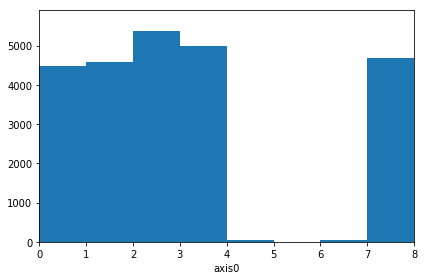

In [21]:
f["all"] = add(one, two, three)
f["all"].physt().plot();

## Modularized file-writing and histogram-conversion

   * all of the histogram-writing code (what bytes go to the file) is in **uproot**
   * all of the code that recognizes different histogram libraries and converts them is in **uproot-methods**

**uproot-methods** can be updated independently from (and more rapidly than) **uproot**.

<img style="margin-left: auto; margin-right: auto; width: 70%" src="abstraction-layers.png"></img>

<img style="float: right; width: 40%" src="pratyush.jpg"></img>

## Credit

The ROOT-writing feature was developed by Pratyush Das, a DIANA-HEP undergraduate fellow.

(Most of the work was writing _anything_ to a ROOT file; histograms were done in the last week!)

## Jagged array operations

Also originally part of uproot, separate **awkward-arrays** into a new library to be generalized and applied beyond ROOT.

<img style="margin-left: auto; margin-right: auto; width: 70%" src="abstraction-layers.png"></img>

Jagged arrays are a minimal unit of nested structure: a list containing lists of varying lengths.

In [22]:
f = uproot.open("HZZ-objects.root")
t = f["events"]

In [23]:
a = t.array("muoniso")     # muon isolation variable; multiple per event
a

<JaggedArray [[4.2001534 2.1510613] [2.1880474] [1.4128217 3.3835042] ... [3.7629452], [0.5508107], [0.]] at 7ff3173e8e80>

The implementation is a façade: these are not millions of list objects in memory but two arrays with methods to make them _behave like_ nested lists.

In [24]:
a.offsets

array([   0,    2,    3, ..., 3823, 3824, 3825])

In [25]:
a.content

array([4.2001534, 2.1510613, 2.1880474, ..., 3.7629452, 0.5508107, 0.       ], dtype=float32)

In [26]:
for i, x in enumerate(a):
    if i == 20:
        break
    print(i, x)

0 [4.2001534 2.1510613]
1 [2.1880474]
2 [1.4128217 3.3835042]
3 [2.7284882 0.5522966]
4 [0.        0.8563976]
5 [0.        1.4929442]
6 [0.6231756 0.       ]
7 [2.4025257]
8 [0. 0.]
9 [0.        1.7698176]
10 [2.0015755 0.6041591]
11 [0.         0.76338214]
12 [1.7191544]
13 [0.]
14 [0.6410858 1.2613294]
15 [0.        2.0141196]
16 [0.88719386 1.5272698 ]
17 [5.685393]
18 [0.76651436 0.        ]
19 [1.1567837 2.0942292 0.6321085]


Introducing additional types, like "table" as a struct of arrays presented as an array of structs, allows us to make tables of jagged arrays or jagged arrays of tables.

In [27]:
a = t.array("muonp4")
a

<JaggedArrayMethods [[TLorentzVector(-52.899, -11.655, -8.1608, 54.779) TLorentzVector(37.738, 0.69347, -11.308, 39.402)] [TLorentzVector(-0.81646, -24.404, 20.2, 31.69)] [TLorentzVector(48.988, -21.723, 11.168, 54.74) TLorentzVector(0.82757, 29.801, 36.965, 47.489)] ... [TLorentzVector(-29.757, -15.304, -52.664, 62.395)], [TLorentzVector(1.1419, 63.61, 162.18, 174.21)], [TLorentzVector(23.913, -35.665, 54.719, 69.556)]] at 7ff312948550>

In [28]:
a.content.content

<Table [<TLorentzVector 0> <TLorentzVector 1> <TLorentzVector 2> ... <TLorentzVector 3822>, <TLorentzVector 3823>, <TLorentzVector 3824>] at 7ff312948518>

In [29]:
a.content.content.columns

['fX', 'fY', 'fZ', 'fE']

In [30]:
a[2]["fX"]       # subscript commutativity: hide the AoS ↔ SoA distinction

array([48.98783112,  0.82756668])

In [31]:
a["fX"][2]

array([48.98783112,  0.82756668])

We can also mix-in methods from **uproot-methods** to make physics-aware objects, arrays, and jagged arrays:

In [32]:
one = a[0][0]; two = a[0][1]; one, two

(TLorentzVector(-52.899, -11.655, -8.1608, 54.779),
 TLorentzVector(37.738, 0.69347, -11.308, 39.402))

In [33]:
one + two

TLorentzVector(-15.162, -10.961, -19.468, 94.181)

In [34]:
(one + two).mass

90.22779776988638

In [35]:
hastwo = (a.counts >= 2); ones = a[hastwo, 0]; twos = a[hastwo, 1]

In [36]:
ones + twos                # the plus operation "commutes" through the array

<ObjectArrayMethods [TLorentzVector(-15.162, -10.961, -19.468, 94.181) TLorentzVector(49.815, 8.0774, 48.133, 102.23) TLorentzVector(98.78, -99.792, 738.94, 757.5) ... TLorentzVector(22.797, -5.2167, 32.613, 100.43), TLorentzVector(28.806, 16.557, -24.978, 95.018), TLorentzVector(2.9387, 18.416, -261.92, 273.35)] at 7ff312e11e10>

In [37]:
(ones + twos).mass         # the mass operation "commutes" through the array

array([90.22779777, 74.74654928, 89.75736376, ..., 92.06495256, 85.44384208, 75.96066262])

<img src="apl-timeline.png" align="right" style="margin-left: 50px; width: 40%"></img>

### Array programming

Expresses regular operations over rectangular data structures in shorthand.

   * Multidimensional slices: `rgb_pixels[0, 50:100, ::3]`
   * Elementwise operations: `all_pz = all_pt * sinh(all_eta)`
   * Broadcasting: `all_phi - 2*pi`
   * Masking: `data[trigger & (pt > 40)]`
   * Fancy indexing: `all_eta[argsort(all_pt)]`
   * Array reduction: `array.sum()` → scalar

Our data are not rectangular, but the syntax can be extended by defining rules for jaggedness.

In [38]:
a2 = a[hastwo]
a2[::2, 0]                                                      # Multidimensional slices

<ObjectArrayMethods [TLorentzVector(-52.899, -11.655, -8.1608, 54.779) TLorentzVector(22.088, -85.835, 403.85, 413.46) TLorentzVector(9.2281, 40.554, -14.642, 44.093) ... TLorentzVector(74.756, -14.698, -113.75, 136.9), TLorentzVector(53.006, -24.486, 13.952, 60.032), TLorentzVector(34.507, 28.84, -150.66, 157.23)] at 7ff312e11d68>

In [39]:
pt = a.pt; eta = a.eta
pt * numpy.sinh(eta)                                            # Elementwise operations

<JaggedArray [[ -8.1607933 -11.3075819] [20.19996834] [11.16828537 36.96519089] ... [-52.66374969], [162.17631531], [54.71943665]] at 7ff3129484e0>

In [40]:
multi_per_event = a.phi; one_per_event = t.array("MET").phi
multi_per_event - one_per_event                                 # Broadcasting

<JaggedArray [[-3.33385136 -0.39073772] [-1.02075184] [-2.99699827 -1.0365802 ] ... [-3.89186587], [2.13301998], [-0.79975049]] at 7ff312948320>

In [41]:
a[a.pt > 40]                                                    # Masking by jagged (selects particles)

<JaggedArrayMethods [[TLorentzVector(-52.899, -11.655, -8.1608, 54.779)] [] [TLorentzVector(48.988, -21.723, 11.168, 54.74)] ... [], [TLorentzVector(1.1419, 63.61, 162.18, 174.21)], [TLorentzVector(23.913, -35.665, 54.719, 69.556)]] at 7ff3129484a8>

In [42]:
a[a.pt.max() > 40]                                              # Masking by flat (selects events)

<JaggedArrayMethods [[TLorentzVector(-52.899, -11.655, -8.1608, 54.779) TLorentzVector(37.738, 0.69347, -11.308, 39.402)] [TLorentzVector(48.988, -21.723, 11.168, 54.74) TLorentzVector(0.82757, 29.801, 36.965, 47.489)] [TLorentzVector(22.088, -85.835, 403.85, 413.46) TLorentzVector(76.692, -13.956, 335.09, 344.04)] ... [TLorentzVector(-39.286, -14.607, 61.716, 74.603)], [TLorentzVector(1.1419, 63.61, 162.18, 174.21)], [TLorentzVector(23.913, -35.665, 54.719, 69.556)]] at 7ff3173b25f8>

In [43]:
i = abs(a.eta).argmax()
i

<JaggedArray [[1] [0] [1] ... [0], [0], [0]] at 7ff31a7407b8>

In [44]:
a[i]                                                            # Fancy indexing

<JaggedArrayMethods [[TLorentzVector(37.738, 0.69347, -11.308, 39.402)] [TLorentzVector(-0.81646, -24.404, 20.2, 31.69)] [TLorentzVector(0.82757, 29.801, 36.965, 47.489)] ... [TLorentzVector(-29.757, -15.304, -52.664, 62.395)], [TLorentzVector(1.1419, 63.61, 162.18, 174.21)], [TLorentzVector(23.913, -35.665, 54.719, 69.556)]] at 7ff3129483c8>

In [45]:
abs(a.eta).max()                                                # Jagged reduction

array([0.29527553, 0.75381369, 1.0412953 , ..., 1.23504687, 1.66533108, 1.06269886])

In [46]:
import awkward                                                                 # Simple, synthetic examples
a = awkward.JaggedArray.fromiter([[   1,     2,    3], [], [    4,    5]])     # to illustrate the idea
b = awkward.JaggedArray.fromiter([[  10,    20,   30], [], [   40,   50]])
m = awkward.JaggedArray.fromiter([[True, False, True], [], [False, True]])
flat  = numpy.array([  100,  200,  300])
mflat = numpy.array([False, True, True])
i = awkward.JaggedArray.fromiter([[2, 1], [], [1, 1, 0, 1]])

In [47]:
a + b                                                                          # Elementwise operations

<JaggedArray [[11 22 33] [] [44 55]] at 7ff3129482b0>

In [48]:
a + flat                                                                       # Broadcasting

<JaggedArray [[101 102 103] [] [304 305]] at 7ff312948978>

In [49]:
a[m]                                                                           # Masking by jagged (selects particles)

<JaggedArray [[1 3] [] [5]] at 7ff3129487f0>

In [50]:
a[mflat]                                                                       # Masking by flat (selects events)

<JaggedArray [[] [4 5]] at 7ff312948ba8>

In [51]:
a[i]                                                                           # Fancy indexing

<JaggedArray [[3 2] [] [5 5 4 5]] at 7ff312948b00>

In [52]:
a.sum()                                                                        # Jagged reduction

array([6, 0, 9])

<img src="logscales.png" style="margin-left: auto; margin-right: auto; width: 90%"></src>

Okay, but what about nested for loops? We want something like a jagged "cross join."

In [53]:
import awkward
a = awkward.JaggedArray.fromiter([[1, 2, 3], [], [4, 5], [6], [7, 8, 9]])
b = awkward.JaggedArray.fromiter([[100, 200], [300], [400], [500, 600, 700], [800, 900]])

In [54]:
a.cross(b).tolist()

[[{'0': 1, '1': 100},
  {'0': 1, '1': 200},
  {'0': 2, '1': 100},
  {'0': 2, '1': 200},
  {'0': 3, '1': 100},
  {'0': 3, '1': 200}],
 [],
 [{'0': 4, '1': 400}, {'0': 5, '1': 400}],
 [{'0': 6, '1': 500}, {'0': 6, '1': 600}, {'0': 6, '1': 700}],
 [{'0': 7, '1': 800},
  {'0': 7, '1': 900},
  {'0': 8, '1': 800},
  {'0': 8, '1': 900},
  {'0': 9, '1': 800},
  {'0': 9, '1': 900}]]

In [55]:
print(a.cross(b)._0)
print(a.cross(b)._1)

[[1 1 2 2 3 3] [] [4 5] [6 6 6] [7 7 8 8 9 9]]
[[100 200 100 200 100 200] [] [400 400] [500 600 700] [800 900 800 900 800 900]]


In [56]:
leptoquarks = t.array("muonp4").cross(t.array("jetp4"))
leptoquarks                                                          # all muon-jet pairs in each event

<JaggedArray [[] [<Row 0>] [] ... [<Row 4057>], [<Row 4058> <Row 4059>], []] at 7ff31295a400>

In [57]:
leptoquarks._0 + leptoquarks._1                                      # the muon in each pair plus the jet in each pair

<JaggedArrayMethods [[] [TLorentzVector(-39.691, -4.5408, 19.305, 75.828)] [] ... [TLorentzVector(-33.472, -52.506, -11.652, 118.35)], [TLorentzVector(-35.219, 73.783, 388.61, 403.79) TLorentzVector(-14.115, 36.434, 174.3, 208.13)], []] at 7ff312e11c88>

In [58]:
(leptoquarks._0 + leptoquarks._1).mass                               # the mass of each pair

<JaggedArray [[] [61.49117266] [] ... [99.96350949], [ 73.10963363 106.82646499], []] at 7ff312e11d30>

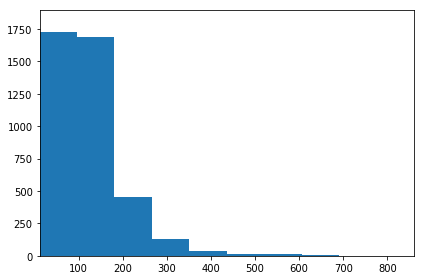

In [59]:
physt.h1((leptoquarks._0 + leptoquarks._1).mass.flatten()).plot();   # a one-line search for leptoquarks

What about nested for loops _without duplicates?_

In [60]:
import awkward
a = awkward.JaggedArray.fromiter([[], [1], [1, 2], [1, 2, 3], [1, 2, 3, 4]])

In [61]:
a.pairs().tolist()

[[],
 [{'0': 1, '1': 1}],
 [{'0': 1, '1': 1}, {'0': 1, '1': 2}, {'0': 2, '1': 2}],
 [{'0': 1, '1': 1},
  {'0': 1, '1': 2},
  {'0': 1, '1': 3},
  {'0': 2, '1': 2},
  {'0': 2, '1': 3},
  {'0': 3, '1': 3}],
 [{'0': 1, '1': 1},
  {'0': 1, '1': 2},
  {'0': 1, '1': 3},
  {'0': 1, '1': 4},
  {'0': 2, '1': 2},
  {'0': 2, '1': 3},
  {'0': 2, '1': 4},
  {'0': 3, '1': 3},
  {'0': 3, '1': 4},
  {'0': 4, '1': 4}]]

In [62]:
a.pairs(same=False).tolist()

[[],
 [],
 [{'0': 1, '1': 2}],
 [{'0': 1, '1': 2}, {'0': 1, '1': 3}, {'0': 2, '1': 3}],
 [{'0': 1, '1': 2},
  {'0': 1, '1': 3},
  {'0': 1, '1': 4},
  {'0': 2, '1': 3},
  {'0': 2, '1': 4},
  {'0': 3, '1': 4}]]

In [63]:
zcandidates = t.array("muonp4").pairs(same=False)
(zcandidates._0 + zcandidates._1).mass

<JaggedArray [[90.22779777] [] [74.74654928] ... [], [], []] at 7ff31295a438>

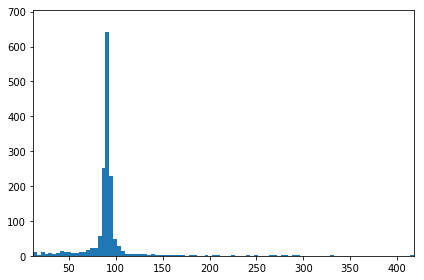

In [64]:
physt.h1((zcandidates._0 + zcandidates._1).mass.flatten(), bins=100).plot();

In [65]:
charges = t.array("muonq").pairs(same=False)
cut = (charges._0 * charges._1 < 0)

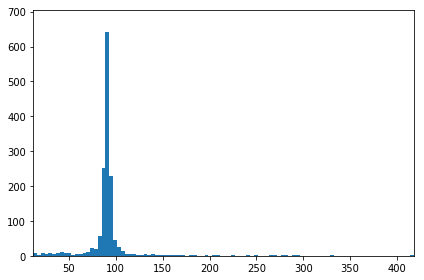

In [66]:
physt.h1((zcandidates[cut]._0 + zcandidates[cut]._1).mass.flatten(), bins=100).plot();

<img style="float: right; width: 10%" src="jaydeep.jpg"></img>

## Credit

Broadcasting, cross, pairs, and a vectorized jagged reduction algorithm were developed by Jaydeep Nandi, a Google Summer of Code student.

None of them involve for loops, not even for loops in C, and are good candidates for GPU acceleration.

<img style="margin-left: auto; margin-right: auto; width: 35%" src="sum_rates_logy.png"></img>

<div style="margin-left: auto; margin-right: auto; width: 70%">
<p>Are there other looping constructs that can't be expressed like this, which would force you to write a for loop?</p>

<p style="font-weight: bold">Probably.</p>

<p>But when you encounter such instances, let me know and we'll think about new primitives beyond "cross" and "pairs" for those cases.</p>
</div>

Purely for streamlined expression (syntactic sugar), a few higher-order functions have been defined.

   * `array.apply(function)` performs `function(array)`
   * `array.filter(function)` performs `array[function(array)]`
   * `array.maxby(function)` performs `array[function(array).argmax()]`
   * `array.minby(function)` performs `array[function(array).argmin()]`

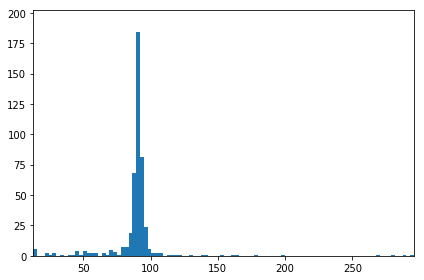

In [67]:
physt.h1(t.array("muonp4")                          # get the muon 4-vectors
          .filter(lambda muon: abs(muon.eta) < 1)   # select central muons (select particles, not events)
          .pairs(same=False)                        # form all non-duplicate pairs
          .apply(lambda a, b: a + b)                # compute Z candidates from as 4-vector sums
          .maxby(lambda z: z.pt)                    # select one per event, the highest pT
          .flatten()                                # flatten [x] → x and [] → nothing (ignore empty events)
          .mass,                                    # compute the masses of what remains
         bins=100).plot();

## Where is this going?

**awkward-array** is distinct from **uproot**, with potential uses on data beyond ROOT files.

In the next few months, I hope to...

   * add support for other "awkward" array types: chunked, masked, indexed
   * add Pandas extensions so that Pandas columns can be "awkward"
   * add Numba extensions so you can write fast for loops if you need to
   * add Dask extensions so you can distribute work across a cluster
   * use Apache Arrow as input, which could allow efficient processing of nested data in PySpark (depending on Spark developments to provide Arrow buffers)

In the meantime, try it out!

<div style="display: block; width: 80%; margin-left: auto; margin-right: auto; margin-top: 100px; margin-bottom: 100px">
    <tt>pip install uproot</tt>
</div>

Live tutorials (Binder) are available on uproot's GitHub site.

**Thanks!**